In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import sys  
import maxentep
import tensorflow as tf

## Basic SIR Model


In [2]:
from maxentep import SIRModel, traj_quantile

# make trajectories
N = 512
L = 60
trajs = np.empty((N, L, 3))
alphas = ss.uniform.rvs(0.01, 0.3, size=N)
betas = ss.uniform.rvs(0.01, 2, size=N)
infected = ss.beta.rvs(1, 10, size=N)
susceptible = ss.beta.rvs(5, 2, size=N)
for i, a, b, I, S in zip(range(N), alphas, betas, infected, susceptible):
    model = SIRModel([S, I, 1 - S - I], a, b, L)
    trajs[i] = model()

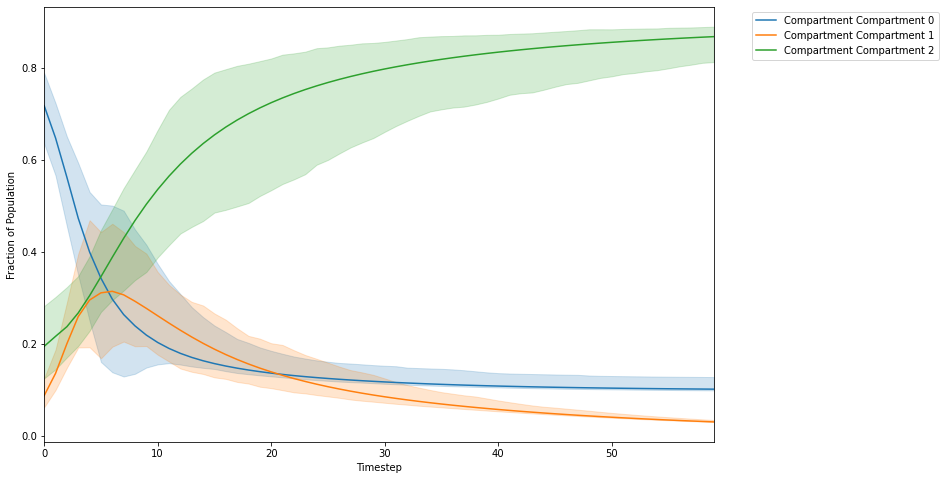

In [3]:
plt.figure(figsize=(12,8))
traj_quantile(trajs)
plt.show()

In [4]:
restraints = [[0.2, 0.05, 10, 1], [0.75, 0.1, 50, 2]]
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i][2:])
    value = restraints[i][0]
    uncertainty = restraints[i][1]
    p = maxentep.Laplace(uncertainty)
    #p = maxentep.EmptyPrior()
    r = maxentep.Restraint(lambda traj, i=traj_index: traj[i], value, p)
    laplace_restraints.append(r)

In [5]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(0.1), 'mean_absolute_error')

Tensor("IteratorGetNext:0", shape=(32, 2), dtype=float32) Tensor("IteratorGetNext:1", shape=(32, 1), dtype=float32)
Tensor("IteratorGetNext:0", shape=(32, 2), dtype=float32) Tensor("IteratorGetNext:1", shape=(32, 1), dtype=float32)


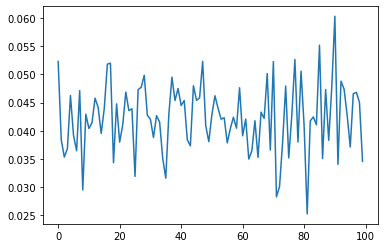

In [6]:
h = model.fit(trajs, batch_size=16, epochs=100, verbose=0)
plt.plot(h.history['loss'])

In [7]:
model.trainable_variables

[<tf.Variable 'maxent-lambda:0' shape=(2,) dtype=float32, numpy=array([1.3986655, 0.8522135], dtype=float32)>]

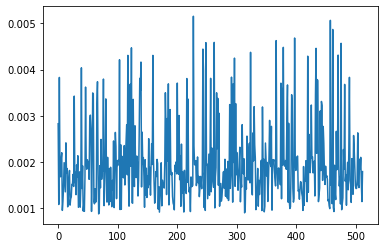

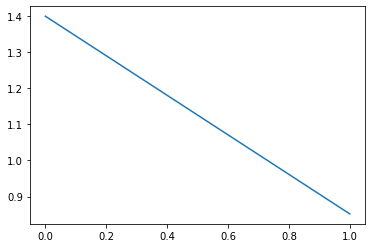

In [8]:
w = model.traj_weights
lambdas = [float(i) for i in model.lambdas.numpy()]
plt.plot(w)
plt.show()
plt.plot(lambdas)
plt.show()

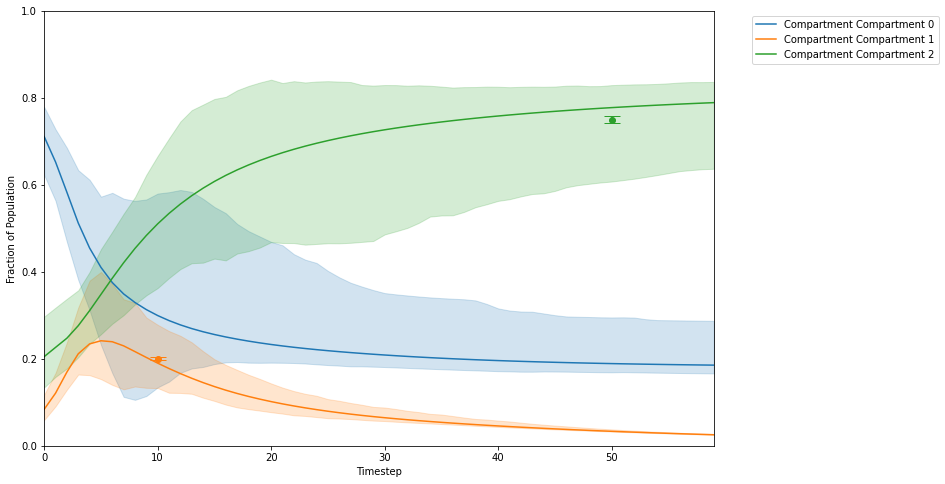

In [9]:
plt.figure(figsize=(12,8))
traj_quantile(trajs, w)
for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):
    plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}')
    plt.errorbar(r[2], r[0], yerr=pr.prior.expected(lambdas[i]), color=f'C{int(r[-1])}', capsize=8)
plt.ylim(0,1)
plt.show()

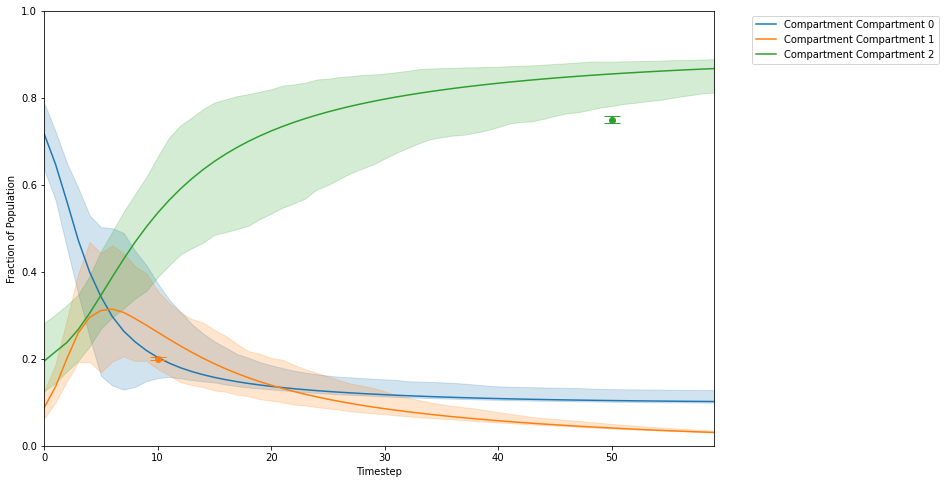

In [10]:
plt.figure(figsize=(12,8))
traj_quantile(trajs)
for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):
    plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}')
    plt.errorbar(r[2], r[0], yerr=pr.prior.expected(lambdas[i]), color=f'C{int(r[-1])}', capsize=8)
plt.ylim(0,1)
plt.show()